In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ================================================= Base VGG-16 Network ================================================================================
#ImageNet pretrained. ( to see if it's the dataset that makes flex lower spearman correlation.)





In [2]:


# ================================================= Flexible Layer ================================================================================

    
class FlexiLayer(nn.Module): # class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        super(FlexiLayer, self).__init__()
        
        self.t_1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.t_2 = nn.MaxPool2d(self.kernel_size, self.stride, self.padding) # get max result with the same kernel size
        self.m = nn.Sigmoid()
        
        self.threshold1 = Variable(torch.randn((1, self.out_channels, 30, 30)))
        
        self.thresh_mean = []
        
    def forward(self, t):
        
        self.threshold1.expand(t.size(0), self.out_channels, 30, 30)
        
        
        cond = torch.sub(self.t_2(t), self.threshold1.cuda())
        t_2_2 = self.m(cond*50)*self.t_2(t) # 
        t_1_1 = self.m(cond*(-50))*self.t_1(t) # 
        t = torch.add(t_2_2, t_1_1)
        
        return t

    # ================================================= VGG-16 Network ================================================================================
class flexVGG16(nn.Module):
    def __init__(self):
        super(flexVGG16,self).__init__()

        self.block1 = nn.Sequential(
                      nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      FlexiLayer(in_channels = 64,out_channels = 64,kernel_size = 3, padding =0),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      #nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.3))

        self.block2 = nn.Sequential(
                      nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block3 = nn.Sequential(
                      nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block4 = nn.Sequential(
                      nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2) ,
                      nn.Dropout2d(0.4))

        self.block5 = nn.Sequential(
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.5) )

        self.fc =     nn.Sequential(
                      nn.Linear(512,100),
                      nn.Dropout(0.5),
                      nn.BatchNorm1d(100),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(100,10), )

    def forward(self,x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)

        return out


In [3]:
'''
Date: 05 June 2020

Python version:      3.7
PyTorch version:     1.2.0

@author: Linnea Evanson

DiCarlo Dataset

Modified 16/01/2021 
By Linnea to train on VGG16 Imagenet pretrained network. -Check if it is the CIFAR10 dataset making the Spearman correlation
lower on the other CIFAR10 flex and baseline.
'''

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from itertools import islice, accumulate
import seaborn as sb
import scipy.spatial.distance
import numpy
import pandas as pd
from torchvision import models
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat

#from models.Flexible_Layer import FlexiLayer #load the Flexilayer class (from models.VGG16_with_flex_v5)


# ======================================== Load the Pretrained Model ==========================================================================================
mean_cifar10 = [0.485, 0.456, 0.406]   #this is the same as for imagenet dataset
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100


# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
fmodel = flexVGG16()
if torch.cuda.is_available():
    fmodel.cuda()
    print("Using cuda")
        
# # Load the pretrained model
fstate = torch.load('models/cifar10_full_nodownsample/VGG16-flex-v5-block1-nnmodule_model_150_90.pth') #, map_location=torch.device('cpu')) #added map_location to specify cpu use

fmodel.load_state_dict(fstate['model'])

fmodel.to(device)
print('Flex layer state loaded')



CUDA Available:  True
Using cuda
Flex layer state loaded


In [4]:
# Use the model object to select the desired layer
flayer = fmodel._modules.get('block5') #choose the second last layer (with features, before the fc layer)
fmodel.eval()

flexVGG16(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): FlexiLayer(
      (t_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (t_2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
      (m): Sigmoid()
    )
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout2d(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padd

In [5]:
#Load the normal VGG16 model:
model = models.vgg16_bn(pretrained=True)  #pretrained on imagenet


if torch.cuda.is_available():
    model.cuda()
    print("Using cuda")


model.to(device)

print('VGG16 state loaded')

layer = model._modules.get('features') #choose the second last layer (with features, before the fc layer)

model.eval()


Using cuda
VGG16 state loaded


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [6]:
#----------------------------------------Functions to scale and transform the images---------------------
scaler = transforms.Scale((32, 32))  #scale to cifar10 size
normalize = transforms.Normalize(mean=mean_cifar10,   #should this be cifar10 or Dicarlo mean & std?
                                 std=std_cifar10)
to_tensor = transforms.ToTensor()

/home/levanson/anaconda3/envs/venv_clone/lib/python3.8/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [7]:
#-----------------------------Function to get the feature vector-----------------------------------

def get_vector(image_name, model, layer,dim ):
    
    img = Image.open(image_name) #Load the image with Pillow library
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)) 
    my_embedding = torch.zeros(512*dim*dim) # Create a vector of zeros that will hold our feature vector
    
    def copy_data(m, i, o): #m =self, i = input, o = output # Define a function that will copy the output of a layer
        #print(o.data.shape)
        my_embedding.copy_(o.data.squeeze().reshape(-1))

    h = layer.register_forward_hook(copy_data) # Attach that function to our selected layer
    model(t_img.to(device))    # Run the model on our transformed image
    h.remove()     # Detach our copy function from the layer

    return my_embedding     #Return the feature vector

In [8]:
def get_array(file):
    annots = loadmat(file)
    print("Meta:     ",type(annots['meta']),annots['meta'].shape)
    print("Features: ",type(annots['features']),annots['features'].shape)

    print("                       Image                               Classification       Train (1)/Test(0)")
    [print("Line 1 of Meta: ",annots['meta'][1])]
    
    feature_length = len(annots['features'][1])
    #Order by category
    count = 0
    animal_features, car_features, chair_features, face_features, fruit_features, plane_features, table_features = [],[],[],[],[],[],[]
    animal_features2, car_features2, chair_features2, face_features2, fruit_features2, plane_features2, table_features2 = [],[],[],[],[],[],[]
    for i in np.nditer(annots['meta']):
        if "Animals" in str(i):
            animal_features.append(annots['features'][count])
            animal_features2.append(annots['meta'][count])
        if 'Cars' in str(i):
            car_features.append(annots['features'][count])
            car_features2.append(annots['meta'][count])
        if 'Chairs' in str(i):
            chair_features.append(annots['features'][count])
            chair_features2.append(annots['meta'][count])
        if 'Faces' in str(i):
            face_features.append(annots['features'][count])
            face_features2.append(annots['meta'][count])
        if 'Fruits' in str(i):
            fruit_features.append(annots['features'][count])
            fruit_features2.append(annots['meta'][count])
        if 'Planes' in str(i):
            plane_features.append(annots['features'][count])
            plane_features2.append(annots['meta'][count])
        if 'Tables' in str(i):
            table_features.append(annots['features'][count])
            table_features2.append(annots['meta'][count])
        count += 1
    ordered_array = np.concatenate((animal_features,car_features,chair_features,face_features,fruit_features,plane_features,table_features), axis = 0) #makes each object a row
    ordered_meta = np.concatenate((animal_features2,car_features2,chair_features2,face_features2,fruit_features2,plane_features2,table_features2), axis = 0) #makes each object a row

    print("done searching file")
    return ordered_array, ordered_meta, feature_length


In [9]:
def get_splits(ordered_meta, ordered_array, feature_length):

    #Get splits    
    rounds = np.zeros((1960,10),dtype=int)
    count = 0
    for line in ordered_meta:
        line_split = []
        for word in line.split():
            line_split.append(word)
        for i in range(10):
            rounds[count][i] = line_split[i+2] #the first two are
        count += 1
    
    #get features for each of the vectors with a 1, put in large array
    features = []
    for i in range(10):
        #temp = np.zeros((392,feature_length)) #an array for 1 of the 10 trials
        perc = 0 #track if 20% is being added to each of the 10 iterations
        temp = []
        for j in range(1960):
            if rounds.T[i][j] == 0: #get only the 20% of test data
                temp.append(ordered_array[j])
                perc += 1
        features.append(temp)
        print("Number of 0 (should be 392)",perc)
    print("We want an array of 10 x 392 x feature_length:")
    print(len(features),len(features[0]),len(features[0][0]))
    
    return features #the array of arrays with the train and test splits for the 10 rounds of 20%

In [10]:
def get_neural_noise(neural_data):
    #Normalise the neural data to have variance of 1: #No need to do this, the data we have has already been normalised
#     scalar = StandardScaler() #use 0 as mean and std as 1
#     scalar.fit(neural_data)
#     neural_scaled = scalar.transform(neural_data) 
    
    #Normalise neural response manually:
    u = np.mean(neural_data.reshape(-1)) #the mean over sites, images and trials        
    std = np.std(neural_data.reshape(-1))
    print("mean unscaled: ", u)

    scaled_data = (neural_data - u)/std
    
    
    print("Normalised var (should be 1): ", np.var(scaled_data))
    us = np.mean(scaled_data.reshape(-1))
    print("mean scaled: ", us)

    #Constants from the paper:
    N = 168 #number of neural sites
    M = 1960 #number of images
    T = 47 #number of trials
    a = 0.14
    b = 0.92 #for multi unit sites
    
    #Calculate variance of the noise:
    sum_u = 0
    for i in range(M):
        for j in range(N):
            sum_u += (a*scaled_data[i][j] + b)**2 #using scaled neural data

    var_noise = (1/(N*M))*sum_u  #Already averaged over trials but still need the /T here perhaps? ******
    print("Var noise: ",var_noise)
    
    #Calculate variance of the signal + noise:
    sum_r = 0
    for i in range(M):
        for j in range(N):
            sum_r += (scaled_data[i][j] - us)**2

    var_sigplusnoise = (1/(N*M)) * sum_r
    print("Var sig+noise:",var_sigplusnoise)

    #Calculate only variance of the signal:
    var_sig = var_sigplusnoise - var_noise
    print("Var sig:",var_sig)
    
    return var_sig

In [11]:
def get_noisy_array(ordered_array, feature_length, neural_sig_variance, c):
    ##Normalise to the std of the IT signal
#     c = Symbol('c') #constant to scale the model by
#     v = np.mean(ordered_array.reshape(-1)) #mean of the model over all images and feature dimensions
#     solve( (1/(feature_length*1960)) *sum([((c*i - v)**2) for i in np.nditer(ordered_array.reshape(-1))]) - neural_sig_variance , c)
    
    #Let's try scaling by a constant 
    #c = 1
    #ordered_array = c*ordered_array
    #print("Variance of normalised array (should be same as sig var): ", np.var(ordered_array.reshape(-1)))
    
    #Try scaling all data to z values (mean 0, std 1):
#     scalar = StandardScaler(with_mean = False, with_std = False) #use 0 as mean and std as 1
#     scalar.fit(ordered_array)
#     scaled_array = scalar.transform(ordered_array) 
    
    #Try scaling using mean 0 and z values:
    u = np.mean(ordered_array.reshape(-1))
    std = np.std(ordered_array.reshape(-1))
    scaled_array = c*(ordered_array - u)/std
    print("var of scaled array (should be same as sig: ", np.var(scaled_array.reshape(-1)))
    #print("Variance of normalised array (should be 1): ", np.var(scaled_array.reshape(-1)))
    
    ##Add IT signal noise:
    a = 0.14
    b = 0.92 # constant from DiCarlo paper, for multi unit sites
    T = 47 #number of trials
    
    noisy_array = np.zeros((1960,feature_length))
    noise = np.random.normal(0,np.sqrt(((a*scaled_array +b)**2)/T)) #have removed the /T here as well
    noisy_array = scaled_array + noise
    print("Var of noisy array:", np.var(noisy_array.reshape(-1)))
    print("found noisy array")
    return noisy_array

In [12]:
def get_mean_array(ordered_array,feature_length,split_marker):  #split_marker is whether it is the whole dataset or 20% splits
    #split_marker = 40 for whole dataset
    #split_marker = 8 for 20% dataset
    objects = [split_marker for i in range(49)] #create 49 groups, of 40 images each (the 49 objects)
    features_split = [ordered_array[x - y: x] for x, y in zip(accumulate(objects), objects)] 
    
    object_means = np.zeros((49,feature_length))

    for i in range(49): #go through all 7 objects
        object_means[i] = np.mean(features_split[i], axis=0)
    print("found mean array")
    return object_means

In [13]:
def calc_rdm(mean_array):
    #Create the RDM matrix
    df = pd.DataFrame(mean_array.T)
    
    #Use pandas dataframe
    rdm = 1 - df.corr()
    print("RDM shape: ",rdm.shape)
    
    return rdm

In [14]:
#Extract meta data so we know classification of each image AND can compare to neural data:
#-------------------------------------------------------------------------

filenames = ['DiCarlo_Lab_Data/NeuralData_IT_multiunits.mat','DiCarlo_Lab_Data/NeuralData_V4_multiunits.mat','DiCarlo_Models/Models_HMAX.mat','DiCarlo_Models/Models_HMO.mat','DiCarlo_Models/Models_Krizhevsky2012.mat','DiCarlo_Models/Models_V1like.mat','DiCarlo_Models/Models_V2like.mat','DiCarlo_Models/Models_ZeilerFergus2013.mat']

rdm = np.zeros((len(filenames),49,49))
rdm_noise = np.zeros((len(filenames),49,49))
rdm_splits = []
#Sizes of each matrix will be different depending on feature length of that file, so use lists.
ordered_array = []
mean_array = []
noisy_array = []
mean_noisy_array = []
normalisation_constants = [0.365,0.365,0.365,0.365,0.365,0.365,0.365,0.365]
splits = []
noise_splits = []
mean_splits = []
mean_noise_splits = []
rdm_splits_noise = []

count = 0
for file in filenames:
    temp, ordered_meta, feature_length = get_array(file)
    ordered_array.append(temp)
    mean_array.append(get_mean_array(ordered_array[count], feature_length,40))
    
    if count == 0: #get the IT array
         neural_sig_variance = get_neural_noise(ordered_array[count])
     
    noisy_array.append(get_noisy_array(ordered_array[count], feature_length,neural_sig_variance, normalisation_constants[count]))
    mean_noisy_array.append(get_mean_array(noisy_array[count], feature_length,40))

    rdm[count] = calc_rdm(mean_array[count])
    rdm_noise[count] = calc_rdm(mean_noisy_array[count])

    #The 20% splits, 10 times, for the spearman calcs only

    splits.append(get_splits(ordered_meta, ordered_array[count], feature_length)) #feature vectors of 20% of the images -doesn't matter the order as we are not going to display the rdm
    mean_splits.append([get_mean_array(i, feature_length,8) for i in splits[count]])

    noise_splits.append([get_noisy_array(np.array(i),feature_length,neural_sig_variance,normalisation_constants[count]) for i in splits[count]])
    mean_noise_splits.append([get_mean_array(i,feature_length,8) for i in noise_splits[count]])
    rdm_splits.append([calc_rdm(i) for i in mean_splits[count]]) #we can use this array to calculate the spearman of each round
    rdm_splits_noise.append([calc_rdm(i) for i in mean_noise_splits[count]])

    count += 1
#-------------------------------------------------------------


Meta:      <class 'numpy.ndarray'> (1960,)
Features:  <class 'numpy.ndarray'> (1960, 168)
                       Image                               Classification       Train (1)/Test(0)
Line 1 of Meta:  images/f6ad757411d3002ef3b6a32f2b366b5a40cb2053.png Fruits 1 1 1 1 1 1 1 1 0 1 
done searching file
found mean array
mean unscaled:  -0.012949659884805472
Normalised var (should be 1):  1.0
mean scaled:  -1.5709278171566842e-17
Var noise:  0.8660000000000048
Var sig+noise: 1.000000000000005
Var sig: 0.13400000000000034
var of scaled array (should be same as sig:  0.13322500000000004
Var of noisy array: 0.15131118984958453
found noisy array
found mean array
RDM shape:  (49, 49)
RDM shape:  (49, 49)
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Numb

RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
Meta:      <class 'numpy.ndarray'> (1960,)
Features:  <class 'numpy.ndarray'> (1960, 1250)
                       Image                               Classification       Train (1)/Test(0)
Line 1 of Meta:  images/f6ad757411d3002ef3b6a32f2b366b5a40cb2053.png Fruits 1 1 1 1 1 1 1 1 0 1 
done searching file
found mean array
var of scaled array (should be same as sig:  0.13322500000000007
Var of noisy array: 0.15130886956904685
found noisy array
found mean array
RDM shape:  (49, 49)
RDM shape:  (49, 49)
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should

found mean array
found mean array
found mean array
found mean array
found mean array
found mean array
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
RDM shape:  (49, 49)
Meta:      <class 'numpy.ndarray'> (1960,)
Features:  <class 'numpy.ndarray'> (1960, 24531)
                       Image                               Classification       Train (1)/Test(0)
Line 1 of Meta:  images/f6ad757411d3002ef3b6a32f2b366b5a40cb2053.png Fruits 1 1 1 1 1 1 1 1 0 1 
done searching file
found mean array
var of scaled array (should be same as sig:  0.1332250000000004
Var of noisy array: 0.15106551427846232
found noisy array
found mean array
RDM shape:  (49

In [15]:
#Save these rdm calculations as we don't need to run them every time:
#These are the rdm we will actually want to display
import pickle

#with open('rdm.pkl', 'wb') as f:
#    pickle.dump(rdm, f)

#with open('rdm_noise.pkl', 'wb') as f:
#    pickle.dump(rdm_noise, f)

#The splits RDM we will use for the Spearman calculations but not display do they don't need to be reloaded or saved 

#Load them back again
#with open('rdm.pkl', 'rb') as f:
#    rdm = pickle.load(f)

#with open('rdm_noise.pkl', 'rb') as f:
#    rdm_noise = pickle.load(f)

In [16]:
#Need to check this for other files -----------------------
annots_flex = loadmat(filenames[0]) #load one of the files to have the category tags of images
image = []
for line in annots_flex['meta']:
    for word in line.split():
        if word.endswith('.png'):
            image.append(word)   


In [17]:
# # Load the images iteratively and run them through the network to find their weights #assuming model.eval is sufficient to prevent saving weights although torch.no_grad could be used as well
# # Can use the indices for the images already found.

# #Find indices of each category (same for flex and normal VGG16)
fruit_indexs_flex = [i for i, value in enumerate(annots_flex['meta']) if ('Fruits' in annots_flex['meta'][i])]
car_indexs_flex = [i for i, value in enumerate(annots_flex['meta']) if ('Cars' in annots_flex['meta'][i])]
animal_indexs_flex = [i for i, value in enumerate(annots_flex['meta']) if ('Animals' in annots_flex['meta'][i])]
plane_indexs_flex = [i for i, value in enumerate(annots_flex['meta']) if ('Planes' in annots_flex['meta'][i])]
chair_indexs_flex = [i for i, value in enumerate(annots_flex['meta']) if ('Chairs' in annots_flex['meta'][i])]
table_indexs_flex = [i for i, value in enumerate(annots_flex['meta']) if ('Tables' in annots_flex['meta'][i])]
face_indexs_flex = [i for i, value in enumerate(annots_flex['meta']) if ('Faces' in annots_flex['meta'][i])]

# #Get flex outputs
ordered_indexs_flex = np.concatenate((animal_indexs_flex,car_indexs_flex,chair_indexs_flex,face_indexs_flex,fruit_indexs_flex,plane_indexs_flex,table_indexs_flex), axis=0) 
#Get outputs from the two models
count = 0
ordered_flex = np.zeros((1960,512*1*1))
ordered_vgg = np.zeros((1960,512*1*1))
for i in ordered_indexs_flex:
    ordered_flex[count] = get_vector("DiCarlo_Lab_Data/%s"% (image[i]),fmodel,flayer,1)
    ordered_vgg[count] = get_vector("DiCarlo_Lab_Data/%s"% (image[i]),model,layer,1)
    print(count*100/1960,"% features extracted")
    count += 1


# #Save the neural data, after running through the network:
numpy.savetxt("ordered_flex256_downsampled.csv", ordered_flex, delimiter=",")
numpy.savetxt("ordered_vgg256_downsampled.csv", ordered_vgg, delimiter=",")

0.0 % features extracted
0.05102040816326531 % features extracted
0.10204081632653061 % features extracted
0.15306122448979592 % features extracted
0.20408163265306123 % features extracted
0.25510204081632654 % features extracted
0.30612244897959184 % features extracted
0.35714285714285715 % features extracted
0.40816326530612246 % features extracted
0.45918367346938777 % features extracted
0.5102040816326531 % features extracted
0.5612244897959183 % features extracted
0.6122448979591837 % features extracted
0.6632653061224489 % features extracted
0.7142857142857143 % features extracted
0.7653061224489796 % features extracted
0.8163265306122449 % features extracted
0.8673469387755102 % features extracted
0.9183673469387755 % features extracted
0.9693877551020408 % features extracted
1.0204081632653061 % features extracted
1.0714285714285714 % features extracted
1.1224489795918366 % features extracted
1.1734693877551021 % features extracted
1.2244897959183674 % features extracted
1.2755

11.020408163265307 % features extracted
11.071428571428571 % features extracted
11.122448979591837 % features extracted
11.173469387755102 % features extracted
11.224489795918368 % features extracted
11.275510204081632 % features extracted
11.326530612244898 % features extracted
11.377551020408163 % features extracted
11.428571428571429 % features extracted
11.479591836734693 % features extracted
11.53061224489796 % features extracted
11.581632653061224 % features extracted
11.63265306122449 % features extracted
11.683673469387756 % features extracted
11.73469387755102 % features extracted
11.785714285714286 % features extracted
11.83673469387755 % features extracted
11.887755102040817 % features extracted
11.938775510204081 % features extracted
11.989795918367347 % features extracted
12.040816326530612 % features extracted
12.091836734693878 % features extracted
12.142857142857142 % features extracted
12.193877551020408 % features extracted
12.244897959183673 % features extracted
12.2

21.785714285714285 % features extracted
21.836734693877553 % features extracted
21.887755102040817 % features extracted
21.93877551020408 % features extracted
21.989795918367346 % features extracted
22.040816326530614 % features extracted
22.091836734693878 % features extracted
22.142857142857142 % features extracted
22.193877551020407 % features extracted
22.244897959183675 % features extracted
22.29591836734694 % features extracted
22.346938775510203 % features extracted
22.397959183673468 % features extracted
22.448979591836736 % features extracted
22.5 % features extracted
22.551020408163264 % features extracted
22.602040816326532 % features extracted
22.653061224489797 % features extracted
22.70408163265306 % features extracted
22.755102040816325 % features extracted
22.806122448979593 % features extracted
22.857142857142858 % features extracted
22.908163265306122 % features extracted
22.959183673469386 % features extracted
23.010204081632654 % features extracted
23.06122448979592

32.5 % features extracted
32.55102040816327 % features extracted
32.60204081632653 % features extracted
32.6530612244898 % features extracted
32.704081632653065 % features extracted
32.755102040816325 % features extracted
32.80612244897959 % features extracted
32.857142857142854 % features extracted
32.90816326530612 % features extracted
32.95918367346939 % features extracted
33.01020408163265 % features extracted
33.06122448979592 % features extracted
33.11224489795919 % features extracted
33.16326530612245 % features extracted
33.214285714285715 % features extracted
33.265306122448976 % features extracted
33.316326530612244 % features extracted
33.36734693877551 % features extracted
33.41836734693877 % features extracted
33.46938775510204 % features extracted
33.52040816326531 % features extracted
33.57142857142857 % features extracted
33.62244897959184 % features extracted
33.673469387755105 % features extracted
33.724489795918366 % features extracted
33.775510204081634 % features e

43.36734693877551 % features extracted
43.41836734693877 % features extracted
43.46938775510204 % features extracted
43.52040816326531 % features extracted
43.57142857142857 % features extracted
43.62244897959184 % features extracted
43.673469387755105 % features extracted
43.724489795918366 % features extracted
43.775510204081634 % features extracted
43.826530612244895 % features extracted
43.87755102040816 % features extracted
43.92857142857143 % features extracted
43.97959183673469 % features extracted
44.03061224489796 % features extracted
44.08163265306123 % features extracted
44.13265306122449 % features extracted
44.183673469387756 % features extracted
44.234693877551024 % features extracted
44.285714285714285 % features extracted
44.33673469387755 % features extracted
44.38775510204081 % features extracted
44.43877551020408 % features extracted
44.48979591836735 % features extracted
44.54081632653061 % features extracted
44.59183673469388 % features extracted
44.642857142857146

54.08163265306123 % features extracted
54.13265306122449 % features extracted
54.183673469387756 % features extracted
54.234693877551024 % features extracted
54.285714285714285 % features extracted
54.33673469387755 % features extracted
54.38775510204081 % features extracted
54.43877551020408 % features extracted
54.48979591836735 % features extracted
54.54081632653061 % features extracted
54.59183673469388 % features extracted
54.642857142857146 % features extracted
54.69387755102041 % features extracted
54.744897959183675 % features extracted
54.795918367346935 % features extracted
54.8469387755102 % features extracted
54.89795918367347 % features extracted
54.94897959183673 % features extracted
55.0 % features extracted
55.05102040816327 % features extracted
55.10204081632653 % features extracted
55.1530612244898 % features extracted
55.204081632653065 % features extracted
55.255102040816325 % features extracted
55.30612244897959 % features extracted
55.357142857142854 % features ex

64.79591836734694 % features extracted
64.84693877551021 % features extracted
64.89795918367346 % features extracted
64.94897959183673 % features extracted
65.0 % features extracted
65.05102040816327 % features extracted
65.10204081632654 % features extracted
65.15306122448979 % features extracted
65.20408163265306 % features extracted
65.25510204081633 % features extracted
65.3061224489796 % features extracted
65.35714285714286 % features extracted
65.40816326530613 % features extracted
65.45918367346938 % features extracted
65.51020408163265 % features extracted
65.56122448979592 % features extracted
65.61224489795919 % features extracted
65.66326530612245 % features extracted
65.71428571428571 % features extracted
65.76530612244898 % features extracted
65.81632653061224 % features extracted
65.86734693877551 % features extracted
65.91836734693878 % features extracted
65.96938775510205 % features extracted
66.0204081632653 % features extracted
66.07142857142857 % features extracted
6

75.66326530612245 % features extracted
75.71428571428571 % features extracted
75.76530612244898 % features extracted
75.81632653061224 % features extracted
75.86734693877551 % features extracted
75.91836734693878 % features extracted
75.96938775510205 % features extracted
76.0204081632653 % features extracted
76.07142857142857 % features extracted
76.12244897959184 % features extracted
76.1734693877551 % features extracted
76.22448979591837 % features extracted
76.27551020408163 % features extracted
76.3265306122449 % features extracted
76.37755102040816 % features extracted
76.42857142857143 % features extracted
76.4795918367347 % features extracted
76.53061224489795 % features extracted
76.58163265306122 % features extracted
76.63265306122449 % features extracted
76.68367346938776 % features extracted
76.73469387755102 % features extracted
76.78571428571429 % features extracted
76.83673469387755 % features extracted
76.88775510204081 % features extracted
76.93877551020408 % features 

86.53061224489795 % features extracted
86.58163265306122 % features extracted
86.63265306122449 % features extracted
86.68367346938776 % features extracted
86.73469387755102 % features extracted
86.78571428571429 % features extracted
86.83673469387755 % features extracted
86.88775510204081 % features extracted
86.93877551020408 % features extracted
86.98979591836735 % features extracted
87.04081632653062 % features extracted
87.09183673469387 % features extracted
87.14285714285714 % features extracted
87.1938775510204 % features extracted
87.24489795918367 % features extracted
87.29591836734694 % features extracted
87.34693877551021 % features extracted
87.39795918367346 % features extracted
87.44897959183673 % features extracted
87.5 % features extracted
87.55102040816327 % features extracted
87.60204081632654 % features extracted
87.65306122448979 % features extracted
87.70408163265306 % features extracted
87.75510204081633 % features extracted
87.8061224489796 % features extracted
8

97.39795918367346 % features extracted
97.44897959183673 % features extracted
97.5 % features extracted
97.55102040816327 % features extracted
97.60204081632654 % features extracted
97.65306122448979 % features extracted
97.70408163265306 % features extracted
97.75510204081633 % features extracted
97.8061224489796 % features extracted
97.85714285714286 % features extracted
97.90816326530613 % features extracted
97.95918367346938 % features extracted
98.01020408163265 % features extracted
98.06122448979592 % features extracted
98.11224489795919 % features extracted
98.16326530612245 % features extracted
98.21428571428571 % features extracted
98.26530612244898 % features extracted
98.31632653061224 % features extracted
98.36734693877551 % features extracted
98.41836734693878 % features extracted
98.46938775510205 % features extracted
98.5204081632653 % features extracted
98.57142857142857 % features extracted
98.62244897959184 % features extracted
98.6734693877551 % features extracted
98

In [18]:
# def get_ordered_meta(annots):

#     #Order by category
#     count = 0
#     animal_features2, car_features2, chair_features2, face_features2, fruit_features2, plane_features2, table_features2 = [],[],[],[],[],[],[]
#     for i in np.nditer(annots['meta']):
#         if "Animals" in str(i):
#             animal_features2.append(annots['meta'][count])
#         if 'Cars' in str(i):
#             car_features2.append(annots['meta'][count])
#         if 'Chairs' in str(i):
#             chair_features2.append(annots['meta'][count])
#         if 'Faces' in str(i):
#             face_features2.append(annots['meta'][count])
#         if 'Fruits' in str(i):
#             fruit_features2.append(annots['meta'][count])
#         if 'Planes' in str(i):
#             plane_features2.append(annots['meta'][count])
#         if 'Tables' in str(i):
#             table_features2.append(annots['meta'][count])
#         count += 1
#     ordered_meta = np.concatenate((animal_features2,car_features2,chair_features2,face_features2,fruit_features2,plane_features2,table_features2), axis = 0) #makes each object a row
#     return ordered_meta

In [19]:
# #Get ordered meta:
# ordered_meta = get_ordered_meta(annots_flex)

# #Save ordered meta:
# numpy.savetxt("ordered_meta.csv", ordered_meta, delimiter=",",fmt='%s')

In [20]:
#Load model outputs

#ordered_flex = np.loadtxt("ordered_flex256_downsampled.csv", delimiter = ",")
#print("loaded ordered flex")
#ordered_vgg = np.loadtxt("ordered_vgg256_downsampled.csv", delimiter = ",")
#print("loaded ordered vgg")
ordered_meta = np.loadtxt("Final-Images_RDM/ordered_meta.csv", delimiter = ',', dtype = 'str')
print("loaded ordered meta")

loaded ordered meta


In [21]:
def get_model_results(ordered_array, ordered_meta, feature_length,neural_sig_variance,normalisation_constant): 
    splits = get_splits(ordered_meta, ordered_array, feature_length) #feature vectors of 20% of the images -doesn't matter the order as we are not going to display the rdm
    mean_splits = [get_mean_array(i, feature_length,8) for i in splits]
    
    noise_splits = [get_noisy_array(np.array(i),feature_length,neural_sig_variance,normalisation_constant) for i in splits]
    mean_noise_splits = [get_mean_array(i,feature_length,8) for i in noise_splits] 
    
    rdm_splits = [calc_rdm(i) for i in mean_splits] #we can use this array to calculate the spearman of each round
    noise_rdm_splits = [calc_rdm(i) for i in mean_noise_splits]
    return rdm_splits, noise_rdm_splits


In [22]:
#Get the 20% 10 time splits for the model outputs(use the same splits defined in the paper)
vgg_feature_length = 512*1*1
flex_feature_length = 512*1*1
vgg_rdm_splits, vgg_noise_rdm_splits = get_model_results(ordered_vgg,ordered_meta, vgg_feature_length,neural_sig_variance,normalisation_constants[0])
flex_rdm_splits, flex_noise_rdm_splits = get_model_results(ordered_flex, ordered_meta, flex_feature_length,neural_sig_variance,normalisation_constants[0])


Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
Number of 0 (should be 392) 392
We want an array of 10 x 392 x feature_length:
10 392 512
found mean array
found mean array
found mean array
found mean array
found mean array
found mean array
found mean array
found mean array
found mean array
found mean array
var of scaled array (should be same as sig:  0.13322499999999993
Var of noisy array: 0.15113807069583063
found noisy array
var of scaled array (should be same as sig:  0.13322499999999998
Var of noisy array: 0.15109748855394656
found noisy array
var of scaled array (should be same as sig:  0.13322500000000004
Var of noisy array: 0.15073017383425674
found noisy array
var of scaled array (should be same as sig:  0.133225
Var of noisy array: 0.1510828

In [23]:
print(ordered_flex.shape)
print(ordered_vgg.shape)

(1960, 512)
(1960, 512)


In [24]:
#Process the VGG16 and Flex outputs:
#feature_length = 512 #for block 5 of VGG16 and Flex networks

mean_flex = get_mean_array(ordered_flex, flex_feature_length,40)
mean_vgg = get_mean_array(ordered_vgg, vgg_feature_length,40)

noise_flex = get_noisy_array(ordered_flex,flex_feature_length,neural_sig_variance,0.365)
noise_vgg = get_noisy_array(ordered_vgg,vgg_feature_length,neural_sig_variance,0.365)

mean_noise_flex = get_mean_array(noise_flex, flex_feature_length,40)
mean_noise_vgg = get_mean_array(noise_vgg, vgg_feature_length,40)


found mean array
found mean array
var of scaled array (should be same as sig:  0.13322499999999995
Var of noisy array: 0.15130114169916575
found noisy array
var of scaled array (should be same as sig:  0.13322499999999998
Var of noisy array: 0.15132446208232875
found noisy array
found mean array
found mean array


In [25]:
def get_top_half(rdm):
    rdm_top = []
    for i in range(49): #create upper tringle 
        for j in range(49):
            if i < j:
                rdm_top.append(rdm[i][j])
    return rdm_top

In [26]:
#Create the 49x49 RDM

df_flex = pd.DataFrame(mean_flex.T)
df_flex_noise = pd.DataFrame(mean_noise_flex.T)
df_vgg = pd.DataFrame(mean_vgg.T)
df_vgg_noise = pd.DataFrame(mean_noise_vgg.T)

#Use pandas dataframe
rdm_flex = 1 - df_flex.corr()  #e-08
rdm_flex_noise = 1 - df_flex_noise.corr() #0.00x

rdm_vgg = 1 - df_vgg.corr()  #e-07
rdm_vgg_noise = 1 - df_vgg_noise.corr()  #0.00x

print(rdm[0])

[[0.         0.28955135 0.71820886 ... 1.10631685 0.76742929 0.85201015]
 [0.28955135 0.         0.9013589  ... 0.86670449 0.64682612 0.71745592]
 [0.71820886 0.9013589  0.         ... 1.12606526 0.79055186 1.27039142]
 ...
 [1.10631685 0.86670449 1.12606526 ... 0.         0.71826081 0.56642671]
 [0.76742929 0.64682612 0.79055186 ... 0.71826081 0.         0.66736092]
 [0.85201015 0.71745592 1.27039142 ... 0.56642671 0.66736092 0.        ]]


(0.0, 49.0, 49.0, 0.0)

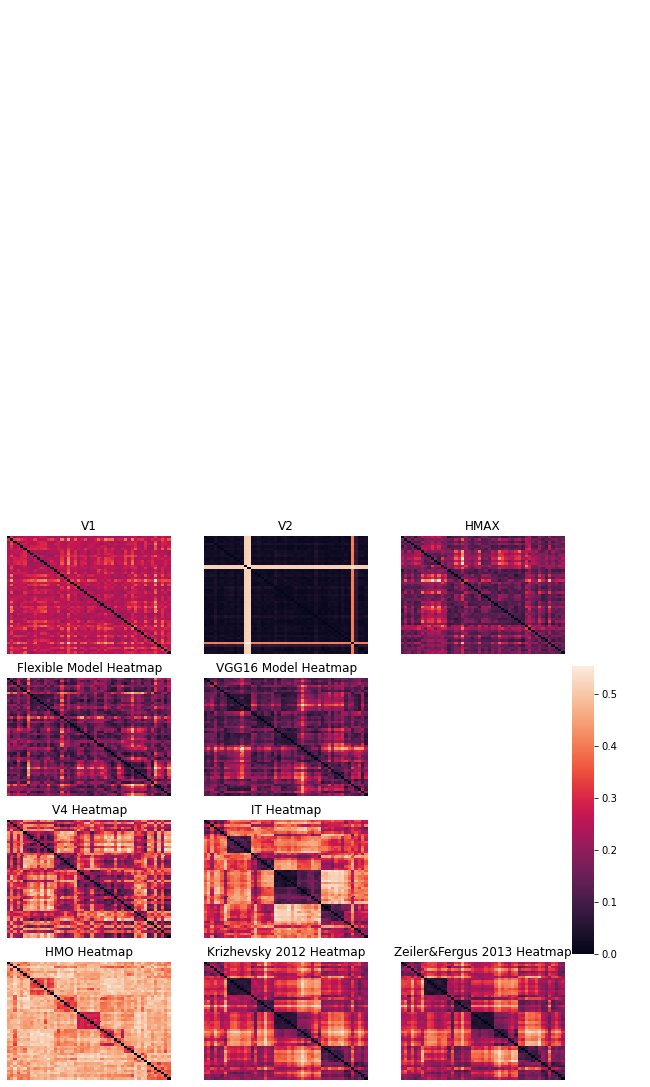

In [27]:
#Plot the RDMs as a Heatmaps
from mpl_toolkits.axes_grid1 import AxesGrid

fig, ((ax11,ax22,ax33),(ax, ax2, a),(ax3,ax4, b),(ax5,ax6,ax7)) = plt.subplots(4, 3, figsize=(10, 10))

cbar_ax = fig.add_axes([.91,.3,.03,.4])

#Let's show V1 and V2 as the spearman values are similar to Flex and VGG16
#order of the rdm matrices: ['Flex','VGG16','V4','HMAX','HMO','Kriv','V1','V2','ZF']


heatmap_V1 = sb.heatmap(rdm[5],ax=ax11,cbar=True,cbar_ax = cbar_ax)
ax11.set_title("V1")
ax11.axis('off')
heatmap_V2 = sb.heatmap(rdm[6],ax=ax22,cbar=True,cbar_ax = cbar_ax)
ax22.set_title("V2")
ax22.axis('off')
heatmap_HMAX = sb.heatmap(rdm[2],ax=ax33,cbar=True,cbar_ax = cbar_ax)
ax33.set_title("HMAX")
ax33.axis('off')

a.axis('off')
b.axis('off')

ax2.axis('off')
heatmap_flex = sb.heatmap(rdm_flex,ax=ax,cbar=True,cbar_ax = cbar_ax)
ax.set_title("Flexible Model Heatmap")
ax.axis('off')
heatmap_vgg = sb.heatmap(rdm_vgg,ax=ax2,cbar=True,cbar_ax=cbar_ax)
ax2.set_title("VGG16 Model Heatmap")
ax2.axis('off')
heatmap_V4 = sb.heatmap(rdm[1],ax=ax3,cbar=True,cbar_ax = cbar_ax)
ax3.set_title("V4 Heatmap")
ax3.axis('off')
heatmap_IT = sb.heatmap(rdm[0],ax=ax4,cbar=True,cbar_ax = cbar_ax)
ax4.set_title("IT Heatmap")
ax4.axis('off')
#HMAX is rdm[2] (not shown in DiCarlo paper)
heatmap_HMO = sb.heatmap(rdm[3],ax=ax5,cbar=True,cbar_ax = cbar_ax)
ax5.set_title("HMO Heatmap")
ax5.axis('off')
heatmap_Krizhevsky = sb.heatmap(rdm[4],ax=ax6,cbar=True,cbar_ax = cbar_ax)
ax6.set_title("Krizhevsky 2012 Heatmap")
ax6.axis('off')
heatmap_ZF = sb.heatmap(rdm[7],ax=ax7,cbar=True,cbar_ax = cbar_ax)
ax7.set_title("Zeiler&Fergus 2013 Heatmap")
ax7.axis('off')


Flex SpearmanrResult(correlation=0.21375592620316075, pvalue=1.2793599918899808e-13)
VGG SpearmanrResult(correlation=0.4253073103642657, pvalue=7.407829165991458e-53)
SpearmanrResult(correlation=0.4056431436075216, pvalue=8.422419117217345e-48)
SpearmanrResult(correlation=0.1768458488078975, pvalue=1.0197425500919126e-09)
SpearmanrResult(correlation=0.4749003534601352, pvalue=3.425611423311086e-67)
SpearmanrResult(correlation=0.7115728920683042, pvalue=3.620016323887429e-182)
SpearmanrResult(correlation=0.09860429545740455, pvalue=0.0007089830123787866)
SpearmanrResult(correlation=0.08640451614402697, pvalue=0.003022366034062199)
SpearmanrResult(correlation=0.7127833482314633, pvalue=4.635225093257367e-183)


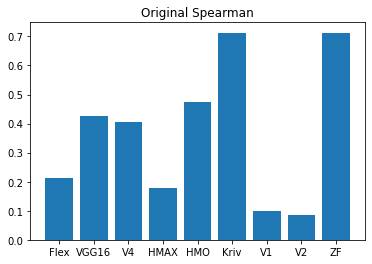

In [28]:
#Compute Spearman correlation between dissimilarity matrices (visualise as bar graph):
#"Between the upper triangular, non-diagonal elements of the two RDMs"
#Compare to rdm[1], which is the IT RDM matrix.
#p-value close to 0 means the correlation is very unlikely to be due to chance

spearman = []
filenames = ['DiCarlo_Lab_Data/NeuralData_IT_multiunits.mat','DiCarlo_Lab_Data/NeuralData_V4_multiunits.mat','DiCarlo_Models/Models_HMAX.mat','DiCarlo_Models/Models_HMO.mat','DiCarlo_Models/Models_Krizhevsky2012.mat','DiCarlo_Models/Models_V1like.mat','DiCarlo_Models/Models_V2like.mat','DiCarlo_Models/Models_ZeilerFergus2013.mat']
# ['Flex','VGG16','V4',HMAX','HMO','Kriv','V1','V2','ZF']

#Keep only upper triangle
rdm_IT_original = get_top_half(rdm[0])
rdm_flex_top = get_top_half(rdm_flex)
rdm_vgg_top = get_top_half(rdm_vgg)

spr = scipy.stats.spearmanr(rdm_flex_top,rdm_IT_original)
spearman.append(spr[0]) #Flex layer
print("Flex",spr)
spr_vgg = scipy.stats.spearmanr(rdm_vgg_top,rdm_IT_original)
spearman.append(spr_vgg[0]) #Flex layer
print("VGG",spr_vgg)
            
for k in range(8):
    if k != 0:
        rdm_temp = get_top_half(rdm[k])
        spr = scipy.stats.spearmanr(rdm_temp,rdm_IT_original)
        print(spr)
        spearman.append(spr[0])
#Create boxplot:
plt.bar([1,2,3,4,5,6,7,8,9],spearman,label='Spearman Correlations',tick_label = ['Flex','VGG16','V4','HMAX','HMO','Kriv','V1','V2','ZF'])
plt.title("Original Spearman")
plt.show()
#Make same order as the paper


Flex SpearmanrResult(correlation=0.7127833482314633, pvalue=4.635225093257367e-183)
VGG SpearmanrResult(correlation=0.4154754667824576, pvalue=2.751716645922378e-50)
SpearmanrResult(correlation=0.40339224335588275, pvalue=3.0402053454479176e-47)
SpearmanrResult(correlation=0.17230639655489807, pvalue=2.728877630753863e-09)
SpearmanrResult(correlation=0.4747642375520681, pvalue=3.779269646777645e-67)
SpearmanrResult(correlation=0.7125770936730229, pvalue=6.584142895580275e-183)
SpearmanrResult(correlation=0.09767834869445526, pvalue=0.0007961470936856127)
SpearmanrResult(correlation=0.019835588097383967, pvalue=0.49678154972773003)
SpearmanrResult(correlation=0.7144532619895514, pvalue=2.6727679879719983e-184)


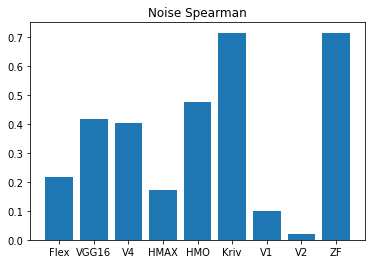

With noise Flex outperforms VGG


In [29]:
#Calculate the noise Spearman histogram
#Compute Spearman correlation between dissimilarity matrices (visualise as bar graph):
#"Between the upper triangular, non-diagonal elements of the two RDMs"
#Compare to rdm[1], which is the IT RDM matrix.
#p-value close to 0 means the correlation is very unlikely to be due to chance

filenames = ['DiCarlo_Lab_Data/NeuralData_V4_multiunits.mat','DiCarlo_Lab_Data/NeuralData_IT_multiunits.mat','DiCarlo_Models/Models_HMAX.mat','DiCarlo_Models/Models_HMO.mat','DiCarlo_Models/Models_Krizhevsky2012.mat','DiCarlo_Models/Models_V1like.mat','DiCarlo_Models/Models_V2like.mat','DiCarlo_Models/Models_ZeilerFergus2013.mat']

spearman = []
#Keep only upper triangle
rdm_IT = get_top_half(rdm[0])
rdm_flex_noise_top = get_top_half(rdm_flex_noise)
rdm_vgg_noise_top = get_top_half(rdm_vgg_noise)

spr_noise = scipy.stats.spearmanr(rdm_flex_noise_top,rdm_IT)
spearman.append(spr_noise[0]) #Add flex layer
print("Flex",spr)
spr_noise_vgg = scipy.stats.spearmanr(rdm_vgg_noise_top,rdm_IT)
spearman.append(spr_noise_vgg[0]) #Add vgg layer
print("VGG",spr_noise_vgg)
            
for k in range(8):
    if k != 0:
        rdm_temp = get_top_half(rdm_noise[k])
        spr = scipy.stats.spearmanr(rdm_temp,rdm_IT)
        print(spr)
        spearman.append(spr[0])
#Create boxplot:
plt.bar([1,2,3,4,5,6,7,8,9],spearman,label='Spearman Correlations',tick_label = ['Flex','VGG16','V4','HMAX','HMO','Kriv','V1','V2','ZF'])
plt.title("Noise Spearman")
plt.show()
#Make same order as the paper (np.sort)

print("With noise Flex outperforms VGG")

(0.0, 49.0, 49.0, 0.0)

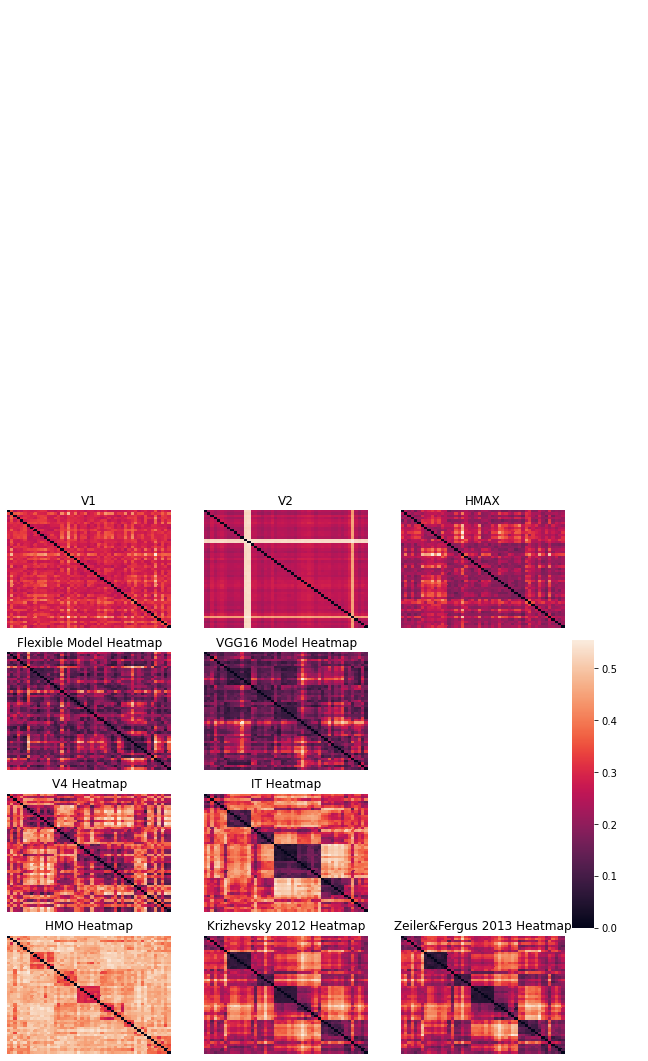

In [30]:
#Print the heatmaps with noise:
#Plot the RDMs as a Heatmaps
fig, ((ax11,ax22,ax33),(ax, ax2, a),(ax3,ax4, b),(ax5,ax6,ax7)) = plt.subplots(4, 3, figsize=(10, 10))

cbar_ax = fig.add_axes([.91,.3,.03,.4])

a.axis('off')
b.axis('off')
ax2.axis('off')

heatmap_V1 = sb.heatmap(rdm_noise[5],ax=ax11,cbar=True,cbar_ax = cbar_ax)
ax11.set_title("V1")
ax11.axis('off')
heatmap_V2 = sb.heatmap(rdm_noise[6],ax=ax22,cbar=True,cbar_ax = cbar_ax)
ax22.set_title("V2")
ax22.axis('off')
heatmap_HMAX = sb.heatmap(rdm_noise[2],ax=ax33,cbar=True,cbar_ax = cbar_ax)
ax33.set_title("HMAX")
ax33.axis('off')


heatmap_flex = sb.heatmap(rdm_flex_noise,ax=ax,cbar=True,cbar_ax = cbar_ax)
ax.set_title("Flexible Model Heatmap")
ax.axis('off')
heatmap_vgg = sb.heatmap(rdm_vgg_noise,ax=ax2,cbar=True,cbar_ax=cbar_ax)
ax2.set_title("VGG16 Model Heatmap")
ax2.axis('off')
heatmap_V4 = sb.heatmap(rdm_noise[1],ax=ax3,cbar=True,cbar_ax = cbar_ax)
ax3.set_title("V4 Heatmap")
ax3.axis('off')
heatmap_IT = sb.heatmap(rdm_noise[0],ax=ax4,cbar=True,cbar_ax = cbar_ax)
ax4.set_title("IT Heatmap")
ax4.axis('off')
#HMAX is rdm[2] (not shown in DiCarlo paper)
heatmap_HMO = sb.heatmap(rdm_noise[3],ax=ax5,cbar=True,cbar_ax = cbar_ax)
ax5.set_title("HMO Heatmap")
ax5.axis('off')
heatmap_Krizhevsky = sb.heatmap(rdm_noise[4],ax=ax6,cbar=True,cbar_ax = cbar_ax)
ax6.set_title("Krizhevsky 2012 Heatmap")
ax6.axis('off')
heatmap_ZF = sb.heatmap(rdm_noise[7],ax=ax7,cbar=True,cbar_ax = cbar_ax)
ax7.set_title("Zeiler&Fergus 2013 Heatmap")
ax7.axis('off')



(0.0, 49.0, 49.0, 0.0)

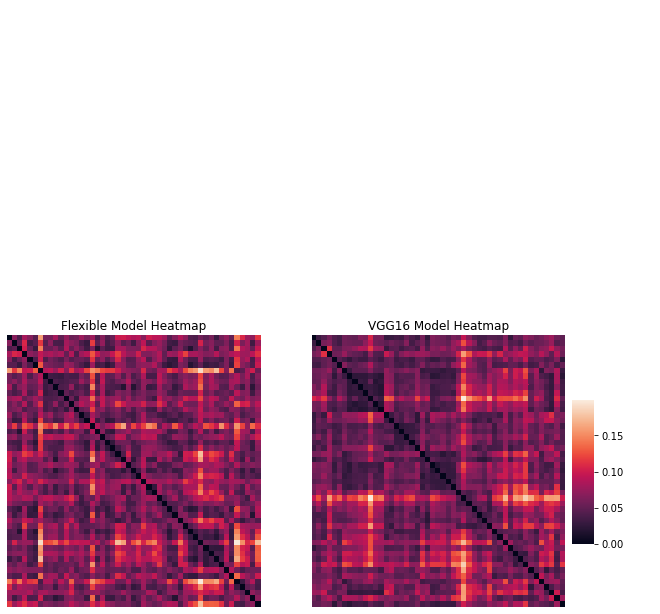

In [31]:
fig, ((ax,ax2)) = plt.subplots(1,2, figsize=(10, 5))

cbar_ax = fig.add_axes([.91,.3,.03,.4])

heatmap_flex = sb.heatmap(rdm_flex_noise,ax=ax,cbar=True,cbar_ax = cbar_ax)
ax.set_title("Flexible Model Heatmap")
ax.axis('off')
heatmap_vgg = sb.heatmap(rdm_vgg_noise,ax=ax2,cbar=True,cbar_ax=cbar_ax)
ax2.set_title("VGG16 Model Heatmap")
ax2.axis('off')

In [32]:
# #Create spearman for just the VGG and Flex models, with noise:
# median_spear = []
# mean_spear = []
# std_error = []

# #For the flex and vgg network:
# spearman_flex = []
# spearman_vgg = []
# for i in range(10): #All 10 iterations of the 20%
#     rdm_flex_top = get_top_half(flex_noise_rdm_splits[i])
#     rdm_vgg_top = get_top_half(vgg_noise_rdm_splits[i])
#     rdm_it = get_top_half(rdm_splits_noise[0][i])

#     spr_flex = scipy.stats.spearmanr(rdm_flex_top,rdm_it)
#     spearman_flex.append(spr_flex[0]) #Flex layer
#     spr_vgg = scipy.stats.spearmanr(rdm_vgg_top,rdm_it)
#     spearman_vgg.append(spr_vgg[0]) #Flex layer
# #Flex
# median_spear.append(np.median(spearman_flex))
# mean_spear.append(np.mean(spearman_flex))
# std_error.append(np.std(spearman_flex))
# #VGG
# median_spear.append(np.median(spearman_vgg))
# mean_spear.append(np.mean(spearman_vgg))
# std_error.append(np.std(spearman_vgg))




In [33]:
#Load the IT split half consistency, from the "IT Flatten" file:
IT_spearman = np.loadtxt("Final-Images_RDM/IT_spearman.csv", delimiter = ",")


8
10
49


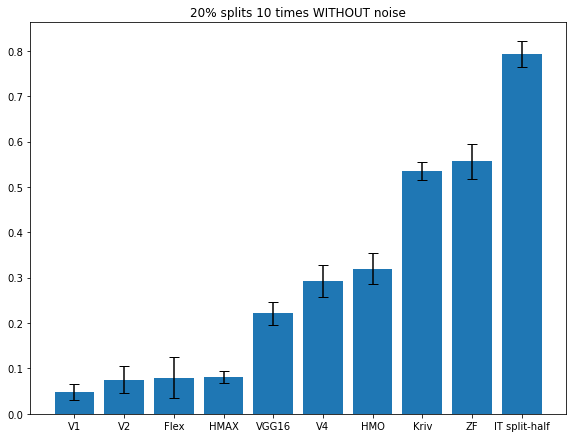

In [34]:
#Let's examine all the RDM's that have been produced for each dataset.
print(len(rdm_splits)) #8 files
print(len(rdm_splits[0]))  #10 splits each 
print(len(rdm_splits[0][0])) #rdm of 49x49 

median_spear = []
mean_spear = []
std_error = []

#For the flex and vgg network:
spearman_flex = []
spearman_vgg = []
for i in range(10): #All 10 iterations of the 20%
    rdm_flex_top = get_top_half(flex_rdm_splits[i])
    rdm_vgg_top = get_top_half(vgg_rdm_splits[i])
    rdm_it = get_top_half(rdm_splits[0][i])

    spr_flex = scipy.stats.spearmanr(rdm_flex_top,rdm_it)
    spearman_flex.append(spr_flex[0]) #Flex layer
    spr_vgg = scipy.stats.spearmanr(rdm_vgg_top,rdm_it)
    spearman_vgg.append(spr_vgg[0]) #Flex layer
#Flex
median_spear.append(np.median(spearman_flex))
mean_spear.append(np.mean(spearman_flex))
std_error.append(np.std(spearman_flex))
#VGG
median_spear.append(np.median(spearman_vgg))
mean_spear.append(np.mean(spearman_vgg))
std_error.append(np.std(spearman_vgg))

#For only the 8 files
filenames = ['DiCarlo_Lab_Data/NeuralData_IT_multiunits.mat','DiCarlo_Lab_Data/NeuralData_V4_multiunits.mat','DiCarlo_Models/Models_HMAX.mat','DiCarlo_Models/Models_HMO.mat','DiCarlo_Models/Models_Krizhevsky2012.mat','DiCarlo_Models/Models_V1like.mat','DiCarlo_Models/Models_V2like.mat','DiCarlo_Models/Models_ZeilerFergus2013.mat']
for k in range(8):
    spearman = [] #Temp to hold all spearman calcs
    if k != 0:
        for i in range(10): #All 10 iterations of the 20%
            rdm_temp = get_top_half(rdm_splits[k][i])
            rdm_it = get_top_half(rdm_splits[0][i])
            spr = scipy.stats.spearmanr(rdm_temp,rdm_it) #compare with the IT rdm
            spearman.append(spr[0])
        median_spear.append(np.median(spearman))
        mean_spear.append(np.mean(spearman))
        std_error.append(np.std(spearman)) #says in the paper that error bars indicate standard deviation over the 10 splits
        #this is /2 as matplot lib draws that amount on either side

        
 #For the IT split half consistency
median_spear.append(np.median(IT_spearman))
std_error.append(np.std(IT_spearman))
        
#Create boxplot:
plt.figure(figsize = [1.5*6.4, 1.5*4.8])

tick_labels = ['Flex','VGG16','V4','HMAX','HMO','Kriv','V1','V2','ZF','IT split-half']
frame = pd.DataFrame(list(zip(median_spear, tick_labels)), columns = ['median_spear','tick_labels'])
frame = frame.sort_values(by = 'median_spear')

#Ordered
plt.bar([1,2,3,4,5,6,7,8,9,10],frame['median_spear'],yerr = std_error, capsize = 5, label='Spearman Correlations',tick_label = frame['tick_labels'])
plt.title("20% splits 10 times WITHOUT noise")
plt.show()

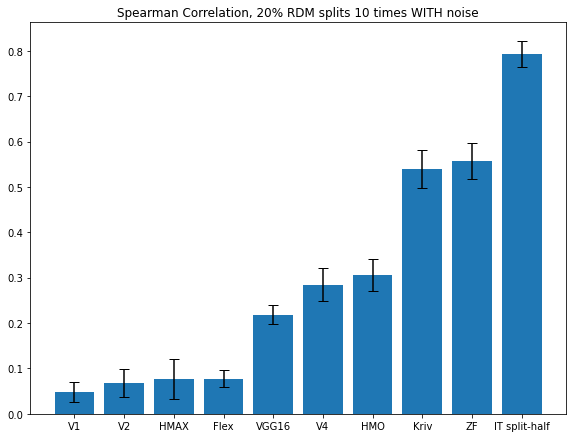

In [35]:
#Print the splits spearman WITH noise as well:
median_spear = []
mean_spear = []
std_error = []

#For the flex and vgg network:
spearman_flex = []
spearman_vgg = []
for i in range(10): #All 10 iterations of the 20%
    rdm_flex_top = get_top_half(flex_noise_rdm_splits[i])
    rdm_vgg_top = get_top_half(vgg_noise_rdm_splits[i])
    rdm_it = get_top_half(rdm_splits_noise[0][i])

    spr_flex = scipy.stats.spearmanr(rdm_flex_top,rdm_it)
    spearman_flex.append(spr_flex[0]) #Flex layer
    spr_vgg = scipy.stats.spearmanr(rdm_vgg_top,rdm_it)
    spearman_vgg.append(spr_vgg[0]) #Flex layer
#Flex
median_spear.append(np.median(spearman_flex))
mean_spear.append(np.mean(spearman_flex))
std_error.append(np.std(spearman_flex))
#VGG
median_spear.append(np.median(spearman_vgg))
mean_spear.append(np.mean(spearman_vgg))
std_error.append(np.std(spearman_vgg))

#For only the 8 files
for k in range(8):
    spearman = [] #Temp to hold all spearman calcs
    if k != 0:
        for i in range(10): #All 10 iterations of the 20%
            rdm_temp = get_top_half(rdm_splits_noise[k][i])
            rdm_it = get_top_half(rdm_splits_noise[0][i])
            spr = scipy.stats.spearmanr(rdm_temp,rdm_it) #compare with the IT rdm
            spearman.append(spr[0])
        median_spear.append(np.median(spearman))
        mean_spear.append(np.mean(spearman))
        std_error.append(np.std(spearman)) #says in the paper that error bars indicate standard deviation over the 10 splits
        #this is /2 as matplot lib draws that amount on either side

        
 #For the IT split half consistency
median_spear.append(np.median(IT_spearman))
std_error.append(np.std(IT_spearman))
        
#Create boxplot:
plt.figure(figsize = [1.5*6.4, 1.5*4.8])

tick_labels = ['Flex','VGG16','V4','HMAX','HMO','Kriv','V1','V2','ZF','IT split-half']
frame = pd.DataFrame(list(zip(median_spear, tick_labels)), columns = ['median_spear','tick_labels'])
frame = frame.sort_values(by = 'median_spear')

#Ordered
plt.bar([1,2,3,4,5,6,7,8,9,10],frame['median_spear'],yerr = std_error, capsize = 5, label='Spearman Correlations',tick_label = frame['tick_labels'])

plt.title("Spearman Correlation, 20% RDM splits 10 times WITH noise")
plt.show()
